# Rasterio

In the previous notebook we focused on the Numpy package using [Rasterio](https://rasterio.readthedocs.io/en/latest/) as the interface to read the data from disk. 

Whereas Numpy is a powerful package for calculation, it does not provide any spatial information so lacking support for reprojection, warping,... Apart from reading in a broad set of GIS raster formats, Rasterio also provides some of these GIS raster operations.

In [48]:
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd

import rasterio
from rasterio.plot import plotting_extent, show, show_hist, reshape_as_image

Let's recap with what we did so far with Rasterio:

In [7]:
data_file = "./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff"

In [8]:
with rasterio.open(data_file) as src:    
    herstappe_data = src.read([1, 2, 3], out_dtype=float, masked=False) # Note the float as output
    herstappe_profile = src.profile
    herstappe_ext = plotting_extent(src)

In [9]:
herstappe_data.shape, herstappe_data.dtype

((3, 227, 447), dtype('float64'))

## Convenient plot functions for data exploration

Rasterio provides dedicated plot functions `show` and `show_hist` for quick ddata exploration:

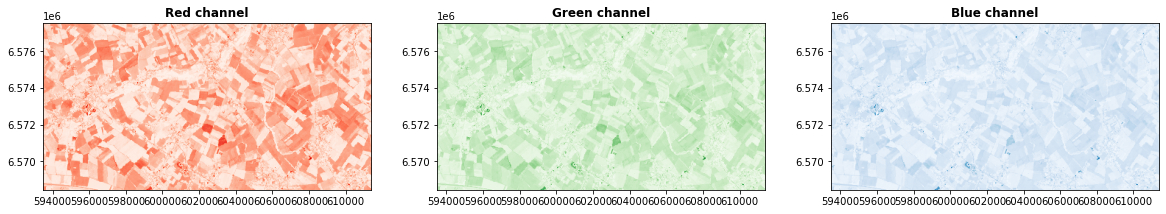

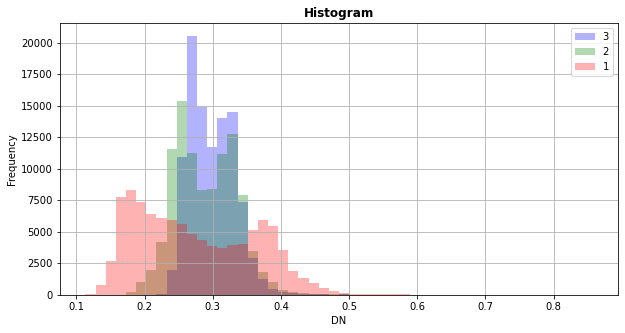

In [10]:
with rasterio.open(data_file) as src:
    
    # convenience plot functions from rasterio
    fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(20, 10))
    show((src, 1), ax=axr, cmap='Reds', title='Red channel')
    show((src, 2), ax=axg, cmap='Greens', title='Green channel')
    show((src, 3), ax=axb, cmap='Blues', title='Blue channel')
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    show_hist(src, bins=50, lw=0.0, stacked=False, 
          alpha=0.3, histtype='stepfilled', title="Histogram")

__Note:__ Rasterio directly interacts with Matplotlib objects, so adjustments starting from the figure can be done using the Matplotlib syntax. For example, change the title and the legend labels:

In [11]:
_, current_labels = ax.get_legend_handles_labels()
current_labels

['3', '2', '1']

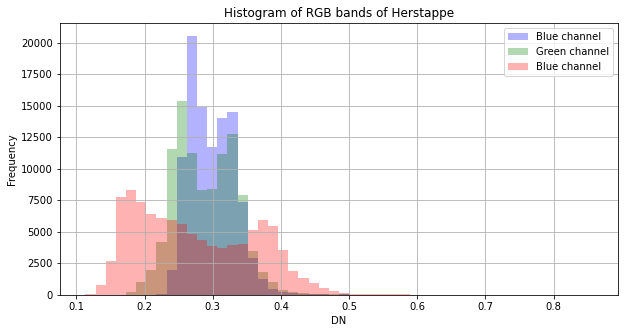

In [12]:
ax.set_title("Histogram of RGB bands of Herstappe")
ax.legend(["Blue channel", "Green channel", "Blue channel"])
fig

__Reminder on opening and Closing File Connections__

The Rasterio library is efficient as it establishes a connection with the raster file rather than directly reading it into memory. Because it creates a connection, it is important that you close the connection after it is opened AND after you’ve finished working with the data! That is why we use the context manager to work with raster data in rasterio. This will handle opening and closing the raster file for you.

__Utility functions for reshaping__

In [13]:
#plt.imshow(herstappe_data)

Python image processing software packages and Matplotlib organize arrays differently than Rasterio. The interpretation of a 3-dimension array read from rasterio is:

`(bands, rows, columns)`

while Matplotlib and image processing software like scikit-image, pillow are generally ordered:

`(rows, columns, bands)`

We can rely on Numpy to transpose the data : 

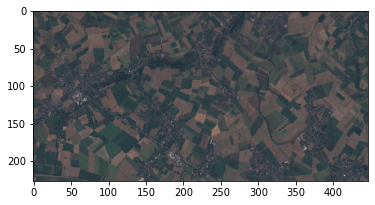

In [14]:
plt.imshow(herstappe_data.transpose(1, 2, 0))

But Rasterio also provides the utility functions `reshape_as_image` and `reshape_as_raster` to support the conversion:

In [15]:
from rasterio.plot import reshape_as_image, reshape_as_raster

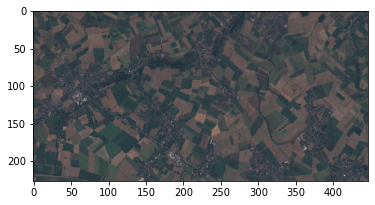

In [16]:
plt.imshow(reshape_as_image(herstappe_data))

## Extract the data you need

In many applications, a specific research area is used. Extracting the data you need from a given raster data set by a vector (polygon) file is a common operation in GIS analysis. We use the clipping example to explain the typical workflow in Rasterio.

For our Herstappe example, the study area is availabe as vector data `./data/herstappe/vector/herstappe.geojson`:

In [17]:
herstappe_vect = gpd.read_file("./data/herstappe/vector/herstappe.geojson")
herstappe_vect

,gml_id,UIDN,OIDN,TERRID,NISCODE,NAAM,DATPUBLBS,NUMAC,geometry
0,Refgem.202,642.0,37.0,59.0,73028,Herstappe,1831-02-07,,"MULTIPOLYGON (((5.41544 50.72148, 5.41568 50.7..."


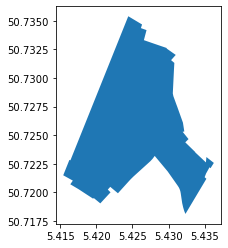

In [18]:
herstappe_vect.plot()

In [19]:
# herstappe_vect.crs  # vs herstappe_profile["crs"]

Make sure both data sets are defined in the same CRS and extracting the geometry can be used as input for the masking:

In [20]:
herstappe_vect = herstappe_vect.to_crs(epsg=3857)

[Masking a raster](https://rasterio.readthedocs.io/en/latest/quickstart.html#dataset-georeferencing) with a geometry in Rasterio is supported by the `rasterio.mask` module:

In [21]:
import rasterio.mask

In [22]:
#?rasterio.mask.mask

The `mask` function by default just masks the image, but it can also be used to `crop` the data by setting the `crop` argument to True:

As the required input for the `shape` to mask with, the documentation defines: 
    
    The values must be a GeoJSON-like dict or an object that implements
    the Python geo interface protocol (such as a Shapely Polygon).
    
We learnt earlier that GeoPandas relies on Shapely as spatial entities:

In [23]:
type(herstappe_vect.geometry), type(herstappe_vect.geometry[0])

(geopandas.geoseries.GeoSeries, shapely.geometry.multipolygon.MultiPolygon)

We can do the data extraction (masking) within the context manager:

In [24]:
data_file = "./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff"

In [25]:
with rasterio.open(data_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, herstappe_vect.geometry, crop=True)
    herstappe_profile = src.profile
    herstappe_ext = plotting_extent(src)

In [26]:
type(out_image)

numpy.ndarray

We can work with `out_image` as a numpy array, but we are lacking the spatial information by doing so, which makes it hard to combine it with other spatial data sets for further analysis:

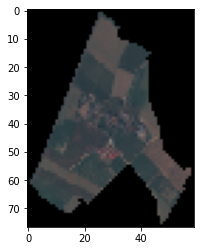

In [27]:
plt.imshow(reshape_as_image(out_image)) # extent ?!? extent=herstappe_ext would not be correct.

Remember the `meta` and the `profile` attributes of the Rasterio object? The latter contains the spatial information and the settings for the GeoTiff file:

In [28]:
herstappe_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 447, 'height': 227, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(40.07813983073409, 0.0, 593476.1968631798,
       0.0, -40.1126034998577, 6577549.60336745), 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}

In [29]:
out_image.shape

(3, 77, 59)

To contain the spatial information or save the file for later usage keeping the spatial information, make sure to __update the profile metadata__ according to the transformations you did. In this case:

- width/height of the cropped image
- affine transform function

In [30]:
herstappe_profile.update({"height": out_image.shape[1],
                          "width": out_image.shape[2],
                          "transform": out_transform})

In [31]:
herstappe_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 59, 'height': 77, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(40.07813983073409, 0.0, 602814.4034437408,
       0.0, -40.1126034998577, 6574661.49591546), 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}

Just as before, we can use the `plotting_extent` function to extract the extent of our data, using the outputs of the masking:

In [32]:
new_extent = plotting_extent(out_image[0], out_transform)  # see docstring of plotting_extent on [0] requirement

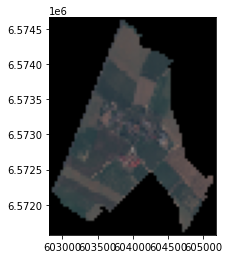

In [33]:
plt.imshow(reshape_as_image(out_image), extent=new_extent)

The updated profile information also allows us to store the output as a Geotiff file:

In [34]:
with rasterio.open("./test.tiff", "w", **herstappe_profile) as dest:
    dest.write(out_image)

Let's read the data we just saved to a file:

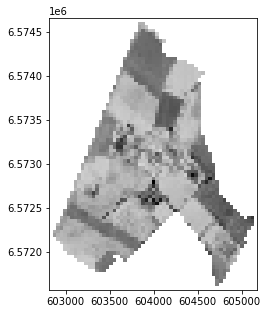

In [35]:
with rasterio.open("./test.tiff") as clipped:
    fig, ax = plt.subplots(figsize=(12, 5))
    show(clipped, (1, 2, 3), cmap='Greys')

    clipped_ext = plotting_extent(clipped)
    clipped_array = clipped.read([1, 2, 3], 
                                 out_dtype=float, masked=False)

Quick check if the extent in both situations are the same:

In [36]:
new_extent == clipped_ext

True

## Rasterio workflow

The workflow applied to clip the data set is typical when working with Rasterio. It consists of the following main steps:

```
# 1
with rasterio.open(data_file) as src:  

    # 2
    out_image, out_transform = rasterio.mask.mask(src, 
        herstappe_vect.geometry, crop=True)    
    
    # 3
    herstappe_profile = src.profile
    herstappe_profile.update({"height": out_image.shape[1],
                              "width": out_image.shape[2],
                              "transform": out_transform})  
    # 4                              
    with rasterio.open("./test.tiff", "w", **herstappe_profile) as dest: 
        dest.write(out_image)
```

- 1. Read in a data set using the context manager
- 2. Read and transform the data set by clipping, resampling,...
- 3. Update the spatial metadata/profile of the data set
- 4. Save the new data set with the updated metadata/profile

Similar operations are:

- Reprojecting a data set, see https://rasterio.readthedocs.io/en/latest/topics/reproject.html
- Resampling a data set, see https://rasterio.readthedocs.io/en/latest/topics/resampling.html
- Create a raster mosaic, see https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html and https://automating-gis-processes.github.io/CSC/notebooks/L5/raster-mosaic.html

Let's apply this workflow to resample our data set with a factor 2, i.e. doubling the pixel size:

In [37]:
data_file = "./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff"

In [38]:
import rasterio
from rasterio.enums import Resampling

scaling_factor = 2 

with rasterio.open(data_file) as src:  # 1

    # resample data to target shape  # 2
    new_width = int(src.width / scaling_factor)
    new_height = int(src.height / scaling_factor)
    out_image = src.read(
        out_shape=(src.count, new_height, new_width),
        resampling=Resampling.bilinear
    )

    # scale image transform and update metadata  # 3
    data_profile = src.profile
    out_transform = src.transform * src.transform.scale(scaling_factor)
    data_profile.update({"height": new_height,
                         "width": new_width,
                         "transform": out_transform})      

    # save the output to disk # 4
    with rasterio.open("./test_resample.tiff", "w", **data_profile) as dst:
        dst.write(out_image)

__Note:__ Other resampling algorithms are available in the `Resampling` module of rasterio.

In [39]:
#!gdalinfo ./data/herstappe/raster/2020-09-17_Sentinel_2_L1C_True_color.tiff
#!gdalinfo ./test_resample.tiff

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

Many of the typical GIS operations provided by Rasterio have a common workflow. In order to preserve the spatial information, make sure to update the attributes such as transform, width and height accordingly before saving the file.

</div>

<div class="alert alert-success">

**EXERCISE**:

You received remote sensing data from Ghent. You're wondering if the remote sensing image covers the entire administrative area of Ghent and decide to make a plot to make the comparison. The vector file of Ghent is available as well, see `./data/herstappe/vector/herstappe.geojson`.
    
Make a plot of `gent_data` (band 4 `./data/gent/raster/2020-09-17_Sentinel_2_L1C_B04.tiff`) together with `gent_vect` (read from `./data/herstappe/vector/herstappe.geojson`) using Matplotlib.
    
    
<details><summary>Hints</summary>

* Make sure to align the CRS of both the vector as the raster data set.
* Remember the `extent` trick to use the coordinates as Matplotlib axis?
* The Matplotlib `plot` function provides `color`, `edgecolor`,... to adjust the style of the plot.
    
</details>
    
</div>

In [40]:
gent_vect = gpd.read_file("./data/gent/vector/gent.geojson")

In [41]:
with rasterio.open("./data/gent/raster/2020-09-17_Sentinel_2_L1C_B04.tiff") as src:
    gent_data = src.read(out_dtype=float, masked=False)
    gent_extent = plotting_extent(src)

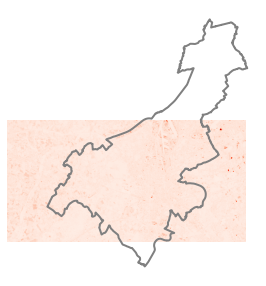

In [42]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.imshow(gent_data.squeeze(), extent=gent_extent, cmap="Reds")  # Extent trick to plot numpy
gent_vect.to_crs(epsg=3857).plot(color='None', edgecolor='grey', linewidth=2, ax=ax)
plt.axis("off");

<div class="alert alert-success">

**EXERCISE**:

The files `./data/gent/raster/2020-09-17_Sentinel_2_L1C_B04.tiff` and `./data/gent/raster/2020-09-17_Sentinel_2_L1C_B08.tiff` are respectively band 4 and 8. Combine them in a single Geotiff file:
    
- Read in each of the data sets with rasterio
- Stack the two data sets with Numpy
- Write the resulting `(2, 317, 625)` array to a new geotiff file `./B0408.tiff` with data type `uint32`
    
    
<details><summary>Hints</summary>

* The workflow is similar to before: you want to read, update the metadata/profile and write the output
* Stacking arrays in Numpy is done by `np.vstack`, converting the dtype by `astype(...)`
* The metadata/profile to update is not the transform, neither the widht/height. Check the `count` and the `dtype` keys of the profile
    
</details>
    
</div>

In [105]:
with rasterio.open("./data/gent/raster/2020-09-17_Sentinel_2_L1C_B04.tiff") as src:
    b4_data = src.read()
    data_profile = src.profile
with rasterio.open("./data/gent/raster/2020-09-17_Sentinel_2_L1C_B08.tiff") as src:
    b8_data = src.read() 

In [106]:
b48_bands = np.vstack((b4_data, b8_data))  # 0 is b4 and 1 is b8  
b48_bands = b48_bands.astype("uint32")
b48_bands.shape

(2, 317, 625)

In [107]:
data_profile.update({"count": 2, 
                     "dtype": "uint32"}) 

with rasterio.open("./B0408.tiff", "w", **data_profile) as dst:
    dst.write(b48_bands)

<div class="alert alert-success">
    
**ADVANCED EXERCISE**:    

You received multiple remte sensing layers of Ghent that need to be resampled. Instead of copy pasting the same code over and over again, you decide to write your own function to resample a file with Rasterio. The inputs of your function are:
    
- input_file : reference to a file on disk
- output_file :  where t write the output 
- resampling_method : method from rasterio.Resampling to use when resampling
- scaling_factor : factor to which the resampling should be applied, default is 2
    
Apply the function on each of the Geotiff files in the folder `./data/gent/raster` (make sure to not overwrite the original files!)
    
<details><summary>Hints</summary>

* Start from the code from the example
* Try to make the function as reusable as possible
* Make sure to document your own function using [numpy docstring](https://numpydoc.readthedocs.io/en/latest/format.html)    
* The [pathlib](https://docs.python.org/3/library/pathlib.html) module is very powerful for working with file systems. Use the `glob` method to find all files with a given extension.
    
</details>
    
</div>

In [543]:
def resample_raster_file(input_file, output_file, resampling_method, scaling_factor=2):
    """Resample a raster file with a given scaling factor using rasterio
    
    Parameters
    ----------
    input_file : str | Path
        Input raster file to resample
    output_file : str | Path
        Output raster file
    resampling_method : rasterio.Resampling
        Method available in the Resampling module of rasterio, e.g. Resampling.bilinear
    scaling_factor : float, default 2
        Scaling factor to use for resampling the data
    
    Examples
    --------
    >>> resample_raster_file("./input_file.tiff", "output_file.tiff", 
    ...                      Resampling.bilinear, scaling_factor=3)
    """
    with rasterio.open(input_file) as src:  
        
        # resample data to target shape
        new_width = int(src.width / scaling_factor)
        new_height = int(src.height / scaling_factor)
        out_image = src.read(
            out_shape=(src.count, new_height, new_width),
            resampling=resampling_method  #Resampling.bilinear
        )

        # scale image transform and update metadata  # 3
        data_profile = src.profile
        out_transform = src.transform * src.transform.scale(scaling_factor)
        data_profile.update({"height": new_height,
                             "width": new_width,
                             "transform": out_transform})      

        # save the output to disk # 4
        with rasterio.open(output_file, "w", **data_profile) as dst:
            dst.write(out_image)    

In [541]:
resample_raster_file("./data/gent/raster/2020-09-17_Sentinel_2_L1C_B04.tiff", 
                     "b4_out.tiff", Resampling.bilinear, scaling_factor=2)

In [546]:
from pathlib import Path

In [552]:
for file in Path("./data/gent/raster").glob("*.tiff"):
    print(f"Converting {file.name}...")
    resample_raster_file(file, Path(f"./{file.name}_resampled.tiff"), Resampling.bilinear, scaling_factor=2)    

Converting 2020-09-17_Sentinel_2_L1C_B03.tiff...
Converting 2020-09-17_Sentinel_2_L1C_B08.tiff...
Converting 2020-09-17_Sentinel_2_L1C_B04.tiff...
Converting 2020-09-17_Sentinel_2_L1C_True_color.tiff...
Converting 2020-09-17_Sentinel_2_L1C_B02.tiff...


<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

When you need to do a particular operation a lot on different files, convert the functionality to a function that you can reuse!

If you are familiar to the command line, using the power of [GDAL](https://gdal.org/index.html) is a valid alternative to programming these conversions with Python/Rasterio. Have a look at [gdalwarp](https://gdal.org/programs/gdalwarp.html) in particular. If interested, the [Using GDAL for preprocessing](https://ocw.un-ihe.org/course/view.php?id=11&section=3) course provides a good introduction to GDAL.

</div>

## BONUS: only download what you need

Rasterio only reads the data from disk that is requested to overcome loading entire data sets into memory. The same applies to downloading data, overcoming entire downloads when only a fraction is required (when the online resource supports this). An example is https://zenodo.org/record/2654620, which is available as [Cloud Optimized Geotiff (COG)](https://www.cogeo.org/). Also cloud provides (AWS, google,...) do support COG files, e.g. [Landstat images](https://docs.opendata.aws/landsat-pds/readme.html).

These files are typically very large to download, whereas we might only need a small subset of the data. COG files do support to downloading a subset of the data you need using the masking approach.

Let's use the Averbode nature reserve data as an example, available at the URL: http://s3-eu-west-1.amazonaws.com/lw-remote-sensing/cogeo/20160401_ABH_1_Ortho.tif

In [478]:
averbode_cog_rgb = 'http://s3-eu-west-1.amazonaws.com/lw-remote-sensing/cogeo/20160401_ABH_1_Ortho.tif'

Check the metadata, without downloading the data itself:

In [462]:
with rasterio.open(averbode_cog_rgb) as averbode:
    print(averbode.count, averbode.width, averbode.height)
    print(averbode.meta)
    averbode_extent = plotting_extent(averbode)

4 37645 35405
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 37645, 'height': 35405, 'count': 4, 'crs': CRS.from_epsg(31370), 'transform': Affine(0.03999903195245761, 0.0, 190775.64103407107,
       0.0, -0.03999903195245824, 192409.09031570077)}


Downloading the entire data set would be 37645*35405 pixels of 8 bit, so more or less 1.3 GByte

In [457]:
37645*35405 / 1e9  # Gb

1.332821225

Assume that we have a study area which is much smaller than the total extent of the available image:

In [515]:
left, right, bottom, top = averbode_extent

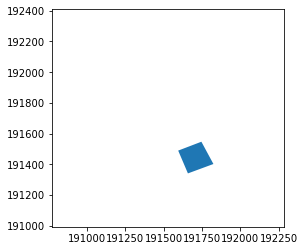

In [516]:
averbode_study_area = gpd.read_file("./data/averbode/study_area.geojson")
ax = averbode_study_area.plot();
ax.set_xlim(left, right);
ax.set_ylim(bottom, top);

In the case of COG data, the data can sometimes be requested on different resolution levels when stored as such. So, to get a very broad overview of the data, we can request the coarsest resolution by resampling and download the data at the resampled resolution:

In [517]:
with rasterio.open(averbode_cog_rgb) as src:
    print(f"Available resolutions are {src.overviews(1)}")
    oview = src.overviews(1)[-1] # list of overviews, selecting the latest (most coarse)
    print(f"Resampling factor= {oview}")
    # Download a resampled version of the data (http://rasterio.readthedocs.io/en/latest/topics/resampling.html), aka thumbnail
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))    

Available resolutions are [2, 4, 8, 16, 32, 64, 128, 254]
Resampling factor= 254


Compare the thumbnail version of the data with our study area:

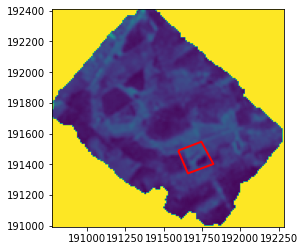

In [518]:
fig, ax = plt.subplots()
ax.imshow(thumbnail, extent=averbode_extent);
averbode_study_area.plot(ax=ax, color='None', edgecolor='red', linewidth=2);

Downloading the entire data file would be overkill. Instead, we only want to download the data of the study area:

In [510]:
output_file = "./averbode_orthophoto.tiff"

The resulting data set will still be around 35MB and will take a bit of time, but this is only a fraction of the original data file:

In [492]:
# Only run this cell when sufficient band width ;-)
with rasterio.open(averbode_cog_rgb) as averbode_rgb:
    averbode_rgb_image, averbode_rgb_transform = rasterio.mask.mask(averbode_rgb, averbode_study_area.geometry, crop=True)
    averbode_rgb_profile = averbode_rgb.profile  

    averbode_rgb_profile.update({"driver": "GTiff",
                                 "height": averbode_rgb_image.shape[1],
                                 "width": averbode_rgb_image.shape[2],
                                 "transform": averbode_rgb_transform
                                })
    
    with rasterio.open(output_file, "w", **averbode_rgb_profile) as dest:
        dest.write(averbode_rgb_image)

Thanks to https://geohackweek.github.io/raster/04-workingwithrasters/ for the inspiration